# AI RADIOLOGY

# Importing Required Libraries

In [2]:
#!pip3 install pandas
#!pip3 install opencv-python
#!pip3 install seaborn
#!pip3 install sklearn

import numpy as np
import pandas as pd
import re
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import sys
import os
from os import mkdir, makedirs
from os.path import exists

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201,preprocess_input,decode_predictions
#from tensorflow.keras.applications.xception import Xception,preprocess_input,decode_predictions

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
from glob import glob

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Looking data directory

In [4]:
os.listdir()

['image3-circle.png',
 'genData',
 'image8-circle.png',
 '.git',
 '.ipynb_checkpoints',
 'image2-circle.png',
 'README.md',
 'image9-circle.png',
 'image10-circle.png',
 'image4-circle.png',
 'image11-circle.png',
 'image5-circle.png',
 '.gitattributes',
 'model_fl.json',
 'Radiology_main.ipynb',
 'my_h5_model.h5',
 'image1-circle.png',
 'image6-circle.png',
 'image7-circle.png',
 'model.h5',
 'MURA-v1.1']

In [5]:
DATASET_PATH = "MURA-v1.1/"
#os.listdir(DATASET_PATH)


def treeStructure(startpath):

    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 2 * (level)
        print('{}|'.format(indent[:]))
        print('{}+{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 2 * (level + 1)

        for f in files:
            print('   {}| +--- {}'.format(subindent[:-5], f))
        
        
            
#treeStructure(DATASET_PATH)

# Load, Merge & Extract feature to CSV

In [6]:
Train_image_df = pd.read_csv(DATASET_PATH + 'train_image_paths.csv', header = None, names = ["Image_Path"])

Val_image_df  = pd.read_csv(DATASET_PATH + 'valid_image_paths.csv', header = None, names = ["Image_Path"])

In [7]:
Train_image_df.shape

(36808, 1)

In [8]:
Val_image_df.shape

(3197, 1)

In [9]:
def generate_labels(data):
    '''Extract label value fromfile path'''
    Labels = []
    
    for idx,row in data.iterrows():
        match = re.search(r'\w(positive)',row[-1]) #regex for str 'positive'
        if match:
            Labels.append('1')
        else:
            Labels.append('0')
    return Labels

def generate_body_part(data):
    '''Extract body part fromfile path'''
    Body_Part = []
    
    for idx,row in data.iterrows():
        match2 = re.search(r'/.*/(.*)/.*/.*/',row[-1])
        body_part_str = match2.group(1)
        Body_Part.append(body_part_str.split('_')[1])
    return Body_Part

def generate_study_type(data):
    '''Extract study type fromfile path'''
    Study_Type = []
    
    for idx,row in data.iterrows():
        match3 = re.search(r'/.*/.*/.*/(.*)/',row[-1]) 
        study_string = match3.group(1)
        Study_Type.append(study_string.split('_')[0])
    return Study_Type

train_labels = generate_labels(Train_image_df)
train_part   = generate_body_part(Train_image_df)
train_study  = generate_study_type(Train_image_df)

Train_image_df['Label']     = train_labels
Train_image_df['Body_Part'] = train_part
Train_image_df['Study_Type']= train_study


val_labels = generate_labels(Val_image_df)
val_part   = generate_body_part(Val_image_df)
val_study  = generate_study_type(Val_image_df)

Val_image_df['Label']      = val_labels
Val_image_df['Body_Part']  = val_part
Val_image_df['Study_Type'] = val_study

In [10]:
Train_image_df[:5]

,Image_Path,Label,Body_Part,Study_Type
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,study1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,study1


# Exploratory Analysis

<AxesSubplot:xlabel='Body_Part'>

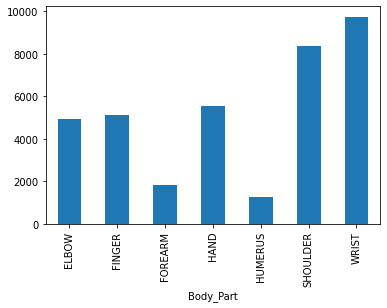

In [11]:
Plt_1 = Train_image_df.groupby(['Body_Part']).size()
Plt_1.plot.bar(x='Body_Part', rot=90)

In [12]:
Train_image_df.groupby(['Study_Type']).size()

Study_Type
study1    35331
study2     1340
study3      109
study4       28
dtype: int64

In [13]:
Train_image_df.groupby(['Body_Part','Label']).count()

Image_Path  Study_Type
Body_Part Label                        
ELBOW     0            2925        2925
          1            2006        2006
FINGER    0            3138        3138
          1            1968        1968
FOREARM   0            1164        1164
          1             661         661
HAND      0            4059        4059
          1            1484        1484
HUMERUS   0             673         673
          1             599         599
SHOULDER  0            4211        4211
          1            4168        4168
WRIST     0            5765        5765
          1            3987        3987

In [14]:
Val_image_df[:5]

,Image_Path,Label,Body_Part,Study_Type
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,WRIST,study1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,WRIST,study1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,WRIST,study1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,WRIST,study1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1,WRIST,study1


In [15]:
Val_image_df.shape

(3197, 4)

Fetching sample records

In [16]:
Sample_df = Train_image_df.groupby(['Label'],group_keys=False).apply(lambda x: x.sample(8000,replace=True))
Sample_df.head()

,Image_Path,Label,Body_Part,Study_Type
19645,MURA-v1.1/train/XR_ELBOW/patient06346/study1_n...,0,ELBOW,study1
18848,MURA-v1.1/train/XR_ELBOW/patient06096/study1_n...,0,ELBOW,study1
4750,MURA-v1.1/train/XR_SHOULDER/patient01545/study...,0,SHOULDER,study1
18258,MURA-v1.1/train/XR_ELBOW/patient05904/study1_n...,0,ELBOW,study1
36191,MURA-v1.1/train/XR_HAND/patient11017/study1_ne...,0,HAND,study1


Data Visulaization

<AxesSubplot:xlabel='Label', ylabel='count'>

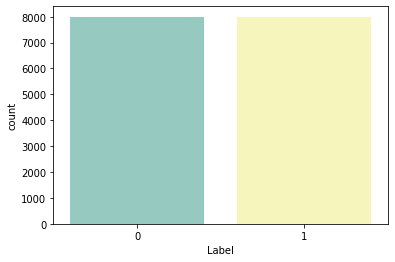

In [17]:
sns.countplot(Sample_df['Label'], palette="Set3")

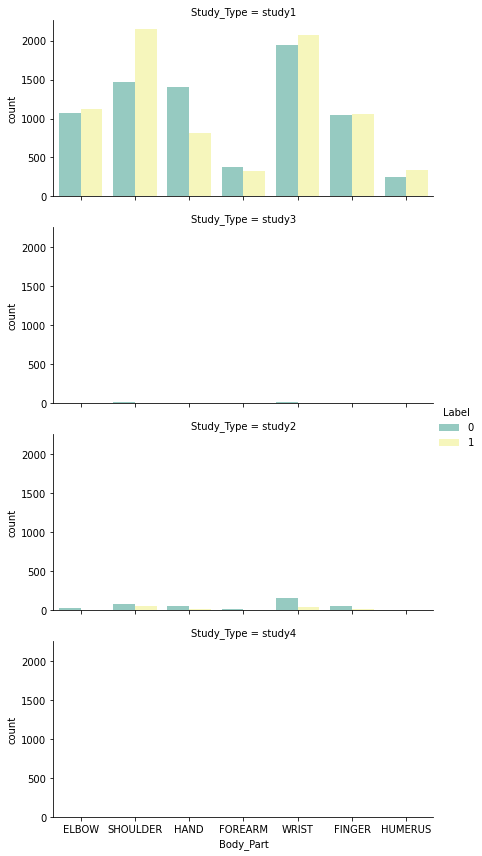

In [18]:
sns.catplot(x="Body_Part", hue="Label", palette="Set3", col="Study_Type",col_wrap=1,

                data=Sample_df, kind="count",

                height=3, aspect=2);

<AxesSubplot:xlabel='Label', ylabel='count'>

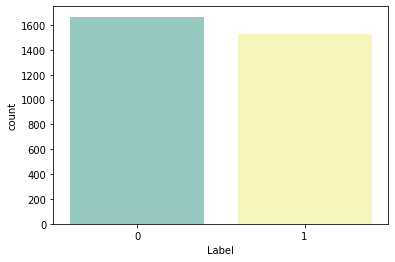

In [19]:
sns.countplot(Val_image_df['Label'], palette="Set3")

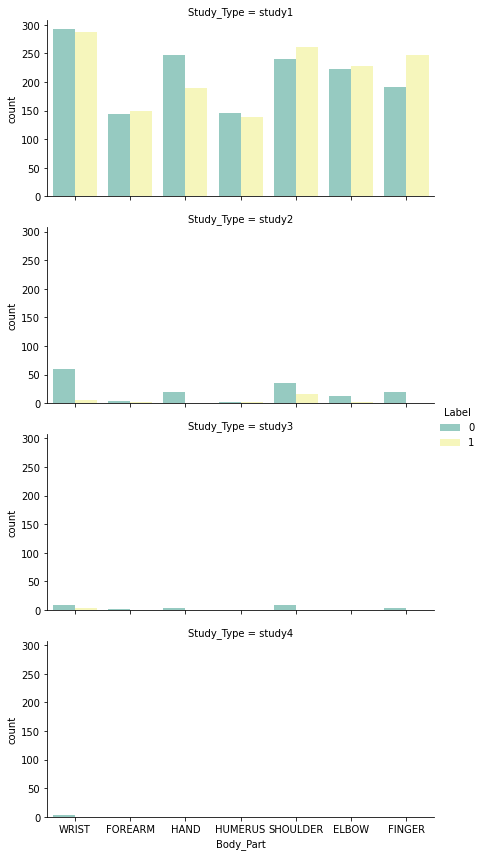

In [20]:
sns.catplot(x="Body_Part", hue="Label", palette="Set3", col="Study_Type",col_wrap=1,

                data=Val_image_df, kind="count",

                height=3, aspect=2);

# Data Preprocessing

In [59]:
crop_size = 224
def csv_process(csv_name, out_dir):

    with open(csv_name, 'r') as csvfile:
        img_reader = csv.reader(csvfile)
        for row in img_reader:
            filename = row[0][0:]
            filename_in = filename
            filename_out = out_dir + filename

            #print(filename_in,filename_out)
            preprocess(filename_in, filename_out)

def preprocess(filename_in, filename_out):

    (head, tail) = os.path.split(filename_in)
    (root, ext) = os.path.splitext(tail)

    img = cv2.imread(filename_in, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    #Content Based Image Retrieval using edge detection
    
    #1.Morph close
    kernel     = np.ones((5, 5), np.uint8)
    morph_img  = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    
    #2.Adaptive histogram equalization. 1 & 2 helps in elimiating texts in images
    clahe         = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8,8))
    ada_eq_img    = clahe.apply(morph_img)
    
    #3.Using edge finder to get the content in image
    smoothed_img = cv2.GaussianBlur(img, (13, 13), sigmaX=0, sigmaY=0)
    edge_finder  = cv2.Canny(smoothed_img, threshold1=0, threshold2=8)
    x, y         = find_act(edge_finder) #Get the X, Y size of content
    
    create_path(filename_out) 
    filename_out_cir = root + "-circle" + ext
    cv2.imwrite(filename_out_cir, edge_finder)
    
    #4. Increase the sharpness of image
    #blur = cv2.GaussianBlur(cl1,(5,5),0)
    #smooth = cv2.addWeighted(blur,1.5,cl1,-0.5,0)
    
    #5. Crop the content of the image
    cv2.imwrite(filename_out, ada_eq_img[x: x+crop_size, y:y+crop_size])
    
def find_act(img):
    img = img.astype(np.int32)
    kernel = np.ones((crop_size, crop_size), img.dtype)
    cnt = np.zeros((crop_size, crop_size), dtype = img.dtype)
    cnt = cv2.filter2D(img, -1, kernel, anchor=(0, 0))
    s = np.argmax(cnt)
    n, m = img.shape
    x = int(s/n)
    y = int(s%m)
    if x+crop_size>n:
        x = n-crop_size
    if y+crop_size>m:
        y = m-crop_size

    return x, y

def create_path(s):
    p = s.rfind("/")
    mk = s[: p]
    if not exists(mk):
        makedirs(mk)

In [60]:
#create_path('genData/')
Train_image_df.to_csv('genData/Train_image_df.csv',index=False,header=False)
csv_process('genData/Train_image_df.csv', 'genData/')

print(os.getcwd())
Val_image_df.to_csv('genData/Test_image_df.csv',index=False,header=False)
csv_process('genData/Test_image_df.csv', 'genData/')

/home/jagan/ML/AIC_Project/AI_Radiologist


In [21]:
print(os.getcwd()) 
os.chdir('genData')
print(os.getcwd()) 

/home/jagan/ML/AIC_Project/AI_Radiologist
/home/jagan/ML/AIC_Project/AI_Radiologist/genData


# Image Generator

/home/jagan/ML/AIC_Project/AI_Radiologist/genData
Found 33128 validated image filenames belonging to 2 classes.
Found 3680 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


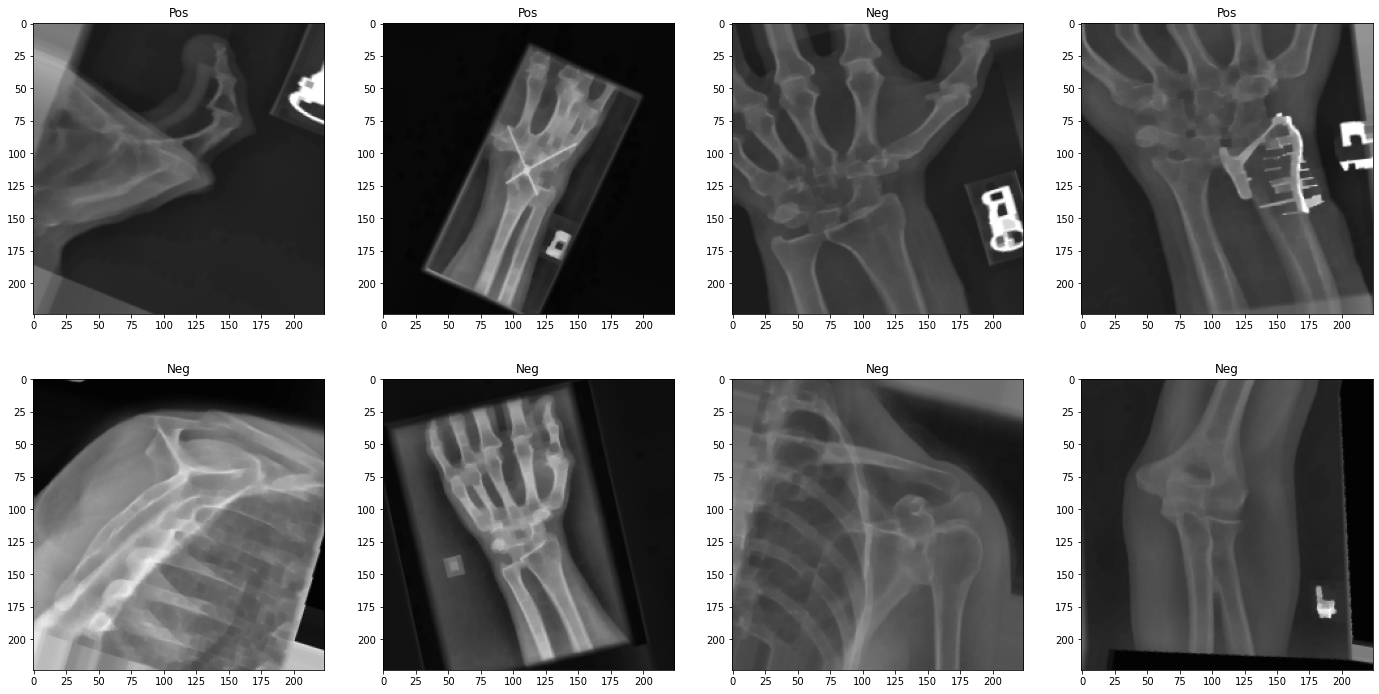

In [22]:
Data_generation_dev = ImageDataGenerator(
                                         rescale = 1. / 255,
                                         horizontal_flip=True,
                                         rotation_range=30,
                                         fill_mode ='nearest',
                                         validation_split=0.1
                                         )

Data_generation_dev.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
Data_generation_dev.std  = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]

print(os.getcwd()) 
train_gen_fl = Data_generation_dev.flow_from_dataframe(
                                                       Train_image_df,
                                                       x_col='Image_Path',
                                                       y_col='Label',
                                                       color_mode='rgb',
                                                       target_size=(224, 224),
                                                       class_mode='binary',
                                                       batch_size = 8,
                                                       shuffle=True,
                                                       subset='training',
                                                       #preprocessing_function = preprocess_input
                                                      )

valid_gen_fl = Data_generation_dev.flow_from_dataframe(
                                                       Train_image_df,
                                                       x_col='Image_Path',
                                                       y_col='Label',
                                                       color_mode='rgb',
                                                       target_size=(224, 244),
                                                       class_mode='binary',
                                                       batch_size = 8,
                                                       shuffle=True,
                                                       subset='validation'
                                                      )
t_x,t_y=next(train_gen_fl)

fig, m_axs = plt.subplots(2, 4, figsize = (24, 12))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,:], cmap = 'bone')
    c_ax.set_title('%s' % ('Pos' if c_y>0.5 else 'Neg'))

Data_generation_test = ImageDataGenerator(rescale = 1. / 255,fill_mode ='nearest') 

test_gen_fl = Data_generation_test.flow_from_dataframe(
                                                       Val_image_df,
                                                       x_col='Image_Path',
                                                       y_col='Label',
                                                       batch_size =8,
                                                       color_mode='rgb',
                                                       target_size=(244, 244),
                                                       class_mode='binary',
                                                       shuffle = True,
                                                       preprocessing_function = preprocess_input
                                                      )

# Train Model

In [23]:
_inputShape = (224, 224, 3)
_pooling    = 'avg'
_learningRate = 0.001

def _xceptionModel(_inputShape, _pooling, _learningRate):
    xpt_model = DenseNet201(weights='imagenet', include_top = False, input_shape=_inputShape, pooling = _pooling)

    xpt_model.trainable = True


    model = tf.keras.models.Sequential([
                                        xpt_model,
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(1, activation='sigmoid')
                                       ])

    model.compile(loss      = tf.keras.losses.binary_crossentropy,
                  optimizer = tf.keras.optimizers.Adam(_learningRate),
                  metrics   = ['binary_accuracy']
                 )
    return model

model = _xceptionModel(_inputShape, _pooling, _learningRate)

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=20)

callbacks_list = [early, cp_callback]

In [ ]:
my_model = model.fit(
                    train_gen_fl, 
                    epochs=50, 
                    validation_data=valid_gen_fl, 
                    steps_per_epoch=len(train_gen_fl) // 8,
                    callbacks = callbacks_list
                   )
                         

Epoch 1/50
517/517 [==============================] - ETA: 0s - loss: 0.6783 - binary_accuracy: 0.6412
Epoch 00001: saving model to training_2/cp.ckpt
517/517 [==============================] - 290s 561ms/step - loss: 0.6783 - binary_accuracy: 0.6412 - val_loss: 1.4291 - val_binary_accuracy: 0.1508
Epoch 2/50
517/517 [==============================] - ETA: 0s - loss: 0.6565 - binary_accuracy: 0.6494
Epoch 00002: saving model to training_2/cp.ckpt
517/517 [==============================] - 226s 438ms/step - loss: 0.6565 - binary_accuracy: 0.6494 - val_loss: 1.2869 - val_binary_accuracy: 0.0598
Epoch 3/50
517/517 [==============================] - ETA: 0s - loss: 0.6593 - binary_accuracy: 0.6385
Epoch 00003: saving model to training_2/cp.ckpt
517/517 [==============================] - 226s 437ms/step - loss: 0.6593 - binary_accuracy: 0.6385 - val_loss: 4.3882 - val_binary_accuracy: 0.7834
Epoch 4/50
517/517 [==============================] - ETA: 0s - loss: 0.6564 - binary_accuracy: 0.64

In [ ]:
model.save("my_h5_model_DN.h5")
model.save_weights("my_model_ckpt_DN")

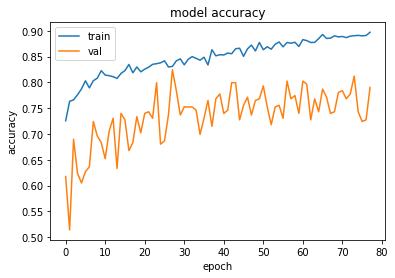

In [31]:
plt.plot(my_model.history['binary_accuracy'])
plt.plot(my_model.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_________________________________________________________________


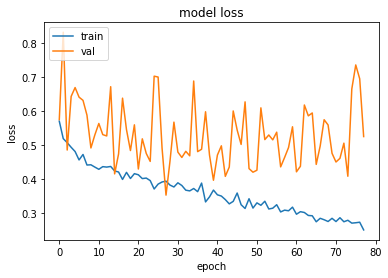

In [34]:
plt.plot(my_model.history['loss'])
plt.plot(my_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
model = keras.models.load_model("my_h5_model.h5")

In [ ]:
history = new_model.fit(
                    train_gen_fl, 
                    epochs=15, 
                    validation_data=valid_gen_fl, 
                    steps_per_epoch=len(train_gen_fl) // 8,
                    callbacks = callbacks_list,
                    verbose=2
                   )
                       

In [36]:
loss, acc = model.evaluate(test_gen_fl, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

400/400 - 54s - loss: 0.6661 - binary_accuracy: 0.7801
Restored model, accuracy: 78.01%


In [43]:
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
xception.outputs

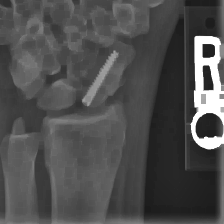

In [54]:


#img = load("MURA-v1.1/valid/XR_SHOULDER/patient11740/study1_positive/image5.png")
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",]

# The local path to our target image
#img_path = "MURA-v1.1/valid/XR_SHOULDER/patient11731/study1_positive/image1.png"
#img_path = "MURA-v1.1/valid/XR_FOREARM/patient11427/study1_positive/image1.png"
#img_path = "MURA-v1.1/valid/XR_ELBOW/patient11326/study1_positive/image4.png"
#img_path = "MURA-v1.1/valid/XR_HUMERUS/patient11556/study1_positive/image2.png"
img_path = "MURA-v1.1/valid/XR_WRIST/patient11207/study1_positive/image1.png"

display(Image(img_path))


In [55]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [56]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4760364fd0> and <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f482917aa00>).


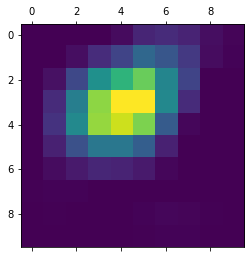

In [57]:
#Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

model = model_builder()
model.load_weights('my_model_ckpt')

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
                               img_array, model, 
                               last_conv_layer_name, 
                               classifier_layer_names
                              )

# Display heatmap
plt.matshow(heatmap)
plt.show()

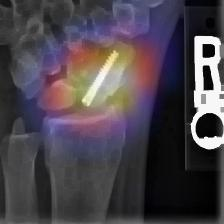

In [58]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
CMRmap = cm.get_cmap("CMRmap")

# We use RGB values of the colormap
CMRmap_colors  = CMRmap(np.arange(256))[:, :3]
CMRmap_heatmap = CMRmap_colors[heatmap]

# We create an image with RGB colorized heatmap
CMRmap_heatmap = keras.preprocessing.image.array_to_img(CMRmap_heatmap)
CMRmap_heatmap = CMRmap_heatmap.resize((img.shape[1], img.shape[0]))
CMRmap_heatmap = keras.preprocessing.image.img_to_array(CMRmap_heatmap)

# Superimpose the heatmap on original image
superimposed_img = CMRmap_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "image_1.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))
